[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/008_numpy_aop/numpy_aop.ipynb)

# Programación Orientada a *Arrays*

En el [post](https://sensioai.com/blog/007_numpy) anterior introdujimos `NumPy` y varias de sus características principales. La principal ventaja que ofrece `NumPy` es la velocidad superior respecto a `Python` en aplicaciones que requieren estructuras de datos numéricas que podemos expresar en forma de vectores, matrices o tensores. Parte de esta mejora viene del hecho que usando `NumPy` podemos llevar a cabo muchos tipos de procesado de datos mediante expresiones concisas aplicadas sobre `arrays` que de otra forma requerirían *loops*. La práctica de sustituir *loops* por expresiones basadas en `arrays` se conoce como `vectorización`, que junto al `broadcasting` forman la base de la programación orientada a array (*Array-Oriented Programming*). En este post vamos a explicar estos conceptos para poder sacar el máximo provecho de `NumPy` y así obtener varios ordenes de magnitud en el *speedup* de nuestro código en `Python`.

## Vectorización

Imaginad que queremos evaluar la función $z = \sqrt{x^2 + y^2 }$ sobre una malla regular de valores. Una manera simple de llevar a cabo esta operación es la siguiente:

In [ ]:
import numpy as np
import math

def lento(n=1000):
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    z = np.empty((n,n))

    for i, _y in enumerate(y):
        for j, _x in enumerate(x):
            z[i, j] = math.sqrt(_x**2 + _y**2)

    return x, y, z

%time x, y, z = lento()

Wall time: 909 ms


Podemos visualizar esta función usando `Matplotlib` (una librería sobre la que hablaremos en detalle en un futuro post).

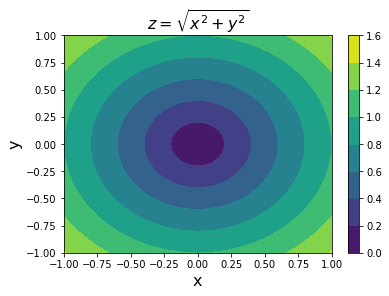

In [ ]:
import matplotlib.pyplot as plt

def plot(x, y, z):
    plt.contourf(x, y, z)
    plt.colorbar()
    plt.xlabel("x", fontsize="16")
    plt.ylabel("y", fontsize="16")
    plt.title("$z = \sqrt{x^2 + y^2 }$", fontsize="16")
    plt.show()

plot(x, y, z)

Como puedes ver en la implementación de la `función` la evaluación de la expresión requiere de dos bucles `for` para iterar sobre todos los valores de `x` e `y` calculando el resultado. Esta es una implementación ineficiente que puede acelerarse si aplicamos la `vectorización`, sustituir bucles por expresiones basadas en `arrays`.

In [ ]:
def rapido(n=1000):
    p = np.linspace(-1,1,n)
    x, y = np.meshgrid(p, p)
    z = np.sqrt(x**2 + y**2)
    return x, y, z

%time x, y, z = rapido()

Wall time: 19 ms


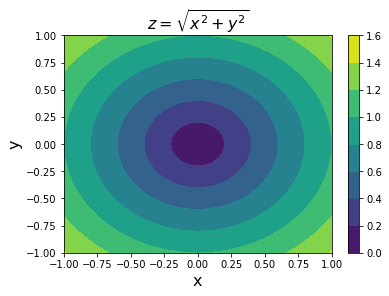

In [ ]:
plot(x, y, z)

El resultado que obtenemos es el mismo, pero 50 veces más rápido. Esto es gracias al uso de la `vectorización`. `NumPy` pone a nuestra disposición multitud de funciones que podemos aprovechar para acelerar nuestros cálculos.

### Funciones Universales

Estas funciones llevan a cabo operaciones elemento a elemento en un `array`. En el ejemplo anterior ya hemos visto una de ellas, `np.sqrt`, para calcular la raíz cuadrada de todos los elementos en un `array` sin necesidad de implementar ningún bucle. Aquí tienes unos cuantos ejemplos.

In [ ]:
a = np.array([[2.5, 3.1, 7], [10, 11, 12]])
a

array([[ 2.5,  3.1,  7. ],
       [10. , 11. , 12. ]])

In [ ]:
for func in (np.abs, np.sqrt, np.exp, np.log, np.sign, np.ceil, np.modf, np.isnan, np.cos):
    print("\n", func.__name__)
    print(func(a))


 absolute
[[ 2.5  3.1  7. ]
 [10.  11.  12. ]]

 sqrt
[[1.58113883 1.76068169 2.64575131]
 [3.16227766 3.31662479 3.46410162]]

 exp
[[1.21824940e+01 2.21979513e+01 1.09663316e+03]
 [2.20264658e+04 5.98741417e+04 1.62754791e+05]]

 log
[[0.91629073 1.13140211 1.94591015]
 [2.30258509 2.39789527 2.48490665]]

 sign
[[1. 1. 1.]
 [1. 1. 1.]]

 ceil
[[ 3.  4.  7.]
 [10. 11. 12.]]

 modf
(array([[0.5, 0.1, 0. ],
       [0. , 0. , 0. ]]), array([[ 2.,  3.,  7.],
       [10., 11., 12.]]))

 isnan
[[False False False]
 [False False False]]

 cos
[[-0.80114362 -0.99913515  0.75390225]
 [-0.83907153  0.0044257   0.84385396]]


### Funciones Estadísticas

Estas funciones nos van a permitir calcular valores estadísticos sobre nuestros `arrays`. Algunos ejemplos son

In [ ]:
for func in (a.min, a.max, a.sum, a.prod, a.std, a.var):
    print(func.__name__, "=", func())

min = 2.5
max = 12.0
sum = 45.6
prod = 71610.0
std = 3.7260345319566395
var = 13.883333333333333


También podemos especificar la dimensión sobre la que queremos calcular estos valores de la siguiente manera

In [ ]:
# calcular valor medio de cada columna

a.mean(axis=0)

array([6.25, 7.05, 9.5 ])

In [ ]:
# suma todos los valores de cada fila

a.sum(axis=1)

array([12.6, 33. ])

## Broadcasting

El `broadcasting` es la segunda propiedad (después de la `vectorización`) que le proporciona a `NumPy` su versatilidad y potencia a la hora de llevar a cabo operaciones con `arrays`. Como norma general, cuando `Numpy` espera `arrays` de la misma forma pero encuentra que esto no se cumple aplica las reglas del `broadcasting`. Vamos a verlas en detalle.  

### Primera regla

Si dos `arrays` no tienen el mismo rango, entonces se añadirá una dimensión de `1` al principio del `array` con menor rango hasta que éstos coincidan.

> 💡 El rango de un `array` es lo mismo que su numero de dimensiones.

Vamos a crear un `array` de 3 dimensiones.

In [ ]:
a = np.arange(5).reshape(1, 1, 5)
a

array([[[0, 1, 2, 3, 4]]])

In [ ]:
a.shape

(1, 1, 5)

Ahora, vamos a sumarle otro `array` de una sola dimension.

In [ ]:
b = np.arange(5)
b

array([0, 1, 2, 3, 4])

In [ ]:
b.shape

(5,)

In [ ]:
a + b

array([[[0, 2, 4, 6, 8]]])

Como puedes ver, `NumPy` no se ha quejado ni nos ha dado ningún error pese a que formalmente esta operación no es válida. Lo que ha ocurrido es que la primera regla del `broadcasting` ha sido aplicada, añadiendo dimensiones extra a nuestro array `b` para convertirlo en una array con dimensiones `(1, 1, 5)` y así poder llevar a cabo la operación. Esta es la misma regla que nos permite sumar un valor escalar a un vector o una matriz.

In [ ]:
1 + a

array([[[1, 2, 3, 4, 5]]])

### Seguna regla

Si un `array` tiene un `1` en alguna dimensión en particular actuará como si tuviese la longitud del `array` con mayor longitud en aquella dimensión. Esto implica que el valor en esta dimensión se repetirá hasta coincidir con la longitud. Por ejemplo

In [ ]:
a = np.arange(6).reshape(2, 3)
a

array([[0, 1, 2],
       [3, 4, 5]])

In [ ]:
a.shape

(2, 3)

In [ ]:
b = np.array([[100], [200]])
b

array([[100],
       [200]])

In [ ]:
b.shape

(2, 1)

Si intentamos sumar estas dos matrices, `NumPy` repetirá los valores de `b` hasta crear tres columnas iguales y así poder llevar a cabo la operación.

In [ ]:
a + b

array([[100, 101, 102],
       [203, 204, 205]])

Las reglas pueden combinares, por ejemplo

In [ ]:
c = np.array([100, 200, 300])
c.shape

(3,)

In [ ]:
a + c

array([[100, 201, 302],
       [103, 204, 305]])

`NumPy` ha añadido una dimensión extra al principio de `c` para obtener una forma de `(1, 3)` y luego ha repetido todos los valores en una nueva fila para obtener una forma de `(2, 3)` y así poder llevar a cabo la suma.

### Tercera regla

Después de aplicar las reglas 1 y 2, las dimensiones de los `arrays` deben coincidir. Si no es así, la operación no se puede llevar a cabo.

In [ ]:
a + [1, 2]

ValueError: operands could not be broadcast together with shapes (2,3) (2,) 

Aquí tienes un ejemplo visual de estas reglas aplicadas sobre varios `arrays`.

![broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/figures/02.05-broadcasting.png)

Estas reglas se aplican en prácticamente todas las operaciones de `NumPy` que requieran dos `arrays`, no solo operaciones aritméticas. Ser capaces de utilizar el `broadcasting` a nuestro favor nos ayudará en la implementación de algoritmos rápidos y eficientes.

## Resumen

En este post hemos hablado sobre programación orientada a `arrays`, un concepto que puede dar como resultado código más rápido y conciso. Este paradigma de programación está basado en la idea de sustituir lentos bucles por operaciones basadas en `arrays` para el procesado de datos. Esta idea se conoce como `vectorización`. En `Python`, utilizamos `NumPy` y sus funciones para conseguir acelerar nuestro código. Una propiedad clave a la hora de conseguir estos resultados es el `broadcasting` que nos permitirá vectorizar nuestro código incluso en aquellas ocasiones en las que, estrictamente hablando, no podríamos (por ejemplo para sumar dos matrices con diferentes dimensiones). Entender estas propiedades y saber aprovecharlas es clave para conseguir implementar algoritmos rápidos y eficientes, algo que utilizaremos de manera extensiva en el análisis de datos y la implementación de algoritmos de Inteligencia Artificial.